# Solubility prediction for organic chemicals

Aqueous solubility is one of the key parameters defining a molecular drug activity.

In this notebook, we will develop models to predict the solubility of organic molecules in water based on their physiochemical
properties. 

In [452]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

from rdkit.Chem import MolStandardize

import joblib

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

from rdkit.Chem import Descriptors,rdMolDescriptors

The data was taken from the database created by Schaper and Raevskaja:
https://doi.org/10.1021/ci400692n

In [453]:
solubility=pd.read_excel(r'solubility.xlsx')

## Basic exploration

In [454]:
solubility.head()

,Formula,name,Molecular weight,S(g/L),S(M/L),"Tmp, C",pK1,pK2,pK3,f(ui),logS,logP
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,35.10,0.398,56.0,NaN,NaN,NaN,1.0,-0.40,1.108
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,7.31,0.100,35.0,NaN,NaN,NaN,1.0,-1.00,1.013
2,C1OCOCO1,"1,3,5-TRIOXANE",90.079,176.00,1.950,64.0,NaN,NaN,NaN,1.0,0.29,-0.446
3,CC(N)=O,ACETAMIDE,59.068,2250.00,38.000,80.0,NaN,NaN,NaN,1.0,1.58,-0.832
4,CC(O)CNCC(C)O,BIS(2-HYDROXYPROPYL)AMINE,133.191,860.00,6.460,44.5,8.97,NaN,NaN,1.0,0.81,-0.540


In [455]:
solubility.shape

(2615, 12)

In [456]:
solubility.columns

Index(['Formula', 'name', 'Molecular weight', 'S(g/L)', 'S(M/L)', 'Tmp, C',
       'pK1', 'pK2', 'pK3', 'f(ui)', 'logS', 'logP'],
      dtype='object')

The data contains the following columns:
    
   **Formula**  contains a Simplified Molecular Input Line Entry System,” which is used to translate a\
   chemical's three-    dimensional structure into a string of symbols;\
   **name** is the IUPAC name of the compound;\
   **Molecular wight** contains molecular weight of a molecule;\
   **S(g/L)** is a solubility in grams per liter;\
   **S(M/L)** is a solubility in mole per liter;\
   **logS** is the natural logarithm of molar solubility;\
   **Tmp, C** is the temperature of the melting point of a substance;\
   **logP** is the value of octanol–water partition coefficient;\
   **pK1**, **pK2** and **pK3** are -log of corresponding constants of dissociation;\
   **f(ui)** - fraction un-ionized;\
   
   We will change Formula column name for smiles since this new name better reflects the data in the column.

In [457]:
solubility.rename(columns={'Formula': 'smiles'},inplace=True)

In [458]:
solubility.dtypes

smiles               object
name                 object
Molecular weight    float64
S(g/L)              float64
S(M/L)              float64
Tmp, C              float64
pK1                 float64
pK2                 float64
pK3                 float64
f(ui)               float64
logS                float64
logP                float64
dtype: object

Most of the variables are floats except for the smiles structure and chemical name.

In [459]:
solubility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   smiles            2615 non-null   object 
 1   name              2615 non-null   object 
 2   Molecular weight  2615 non-null   float64
 3   S(g/L)            2615 non-null   float64
 4   S(M/L)            2615 non-null   float64
 5   Tmp, C            2352 non-null   float64
 6   pK1               1383 non-null   float64
 7   pK2               418 non-null    float64
 8   pK3               75 non-null     float64
 9   f(ui)             2607 non-null   float64
 10  logS              2615 non-null   float64
 11  logP              2615 non-null   float64
dtypes: float64(10), object(2)
memory usage: 245.3+ KB


There are missing values for pK1, pK2 and pK3 dissociation constants and temperature.

In [460]:
solubility.isnull().sum()

smiles                 0
name                   0
Molecular weight       0
S(g/L)                 0
S(M/L)                 0
Tmp, C               263
pK1                 1232
pK2                 2197
pK3                 2540
f(ui)                  8
logS                   0
logP                   0
dtype: int64

### Target variable : solubility

In this project, we will use some physiochemical properties of molecules to predict their solubility in water.

The dataset contains solubility values in g/L, Mol/L, log Sexp, and log Suni : columns **S(g/L)**, **S(M/L)**,  and 
    **logS**.
    
Let us take a look at this data.

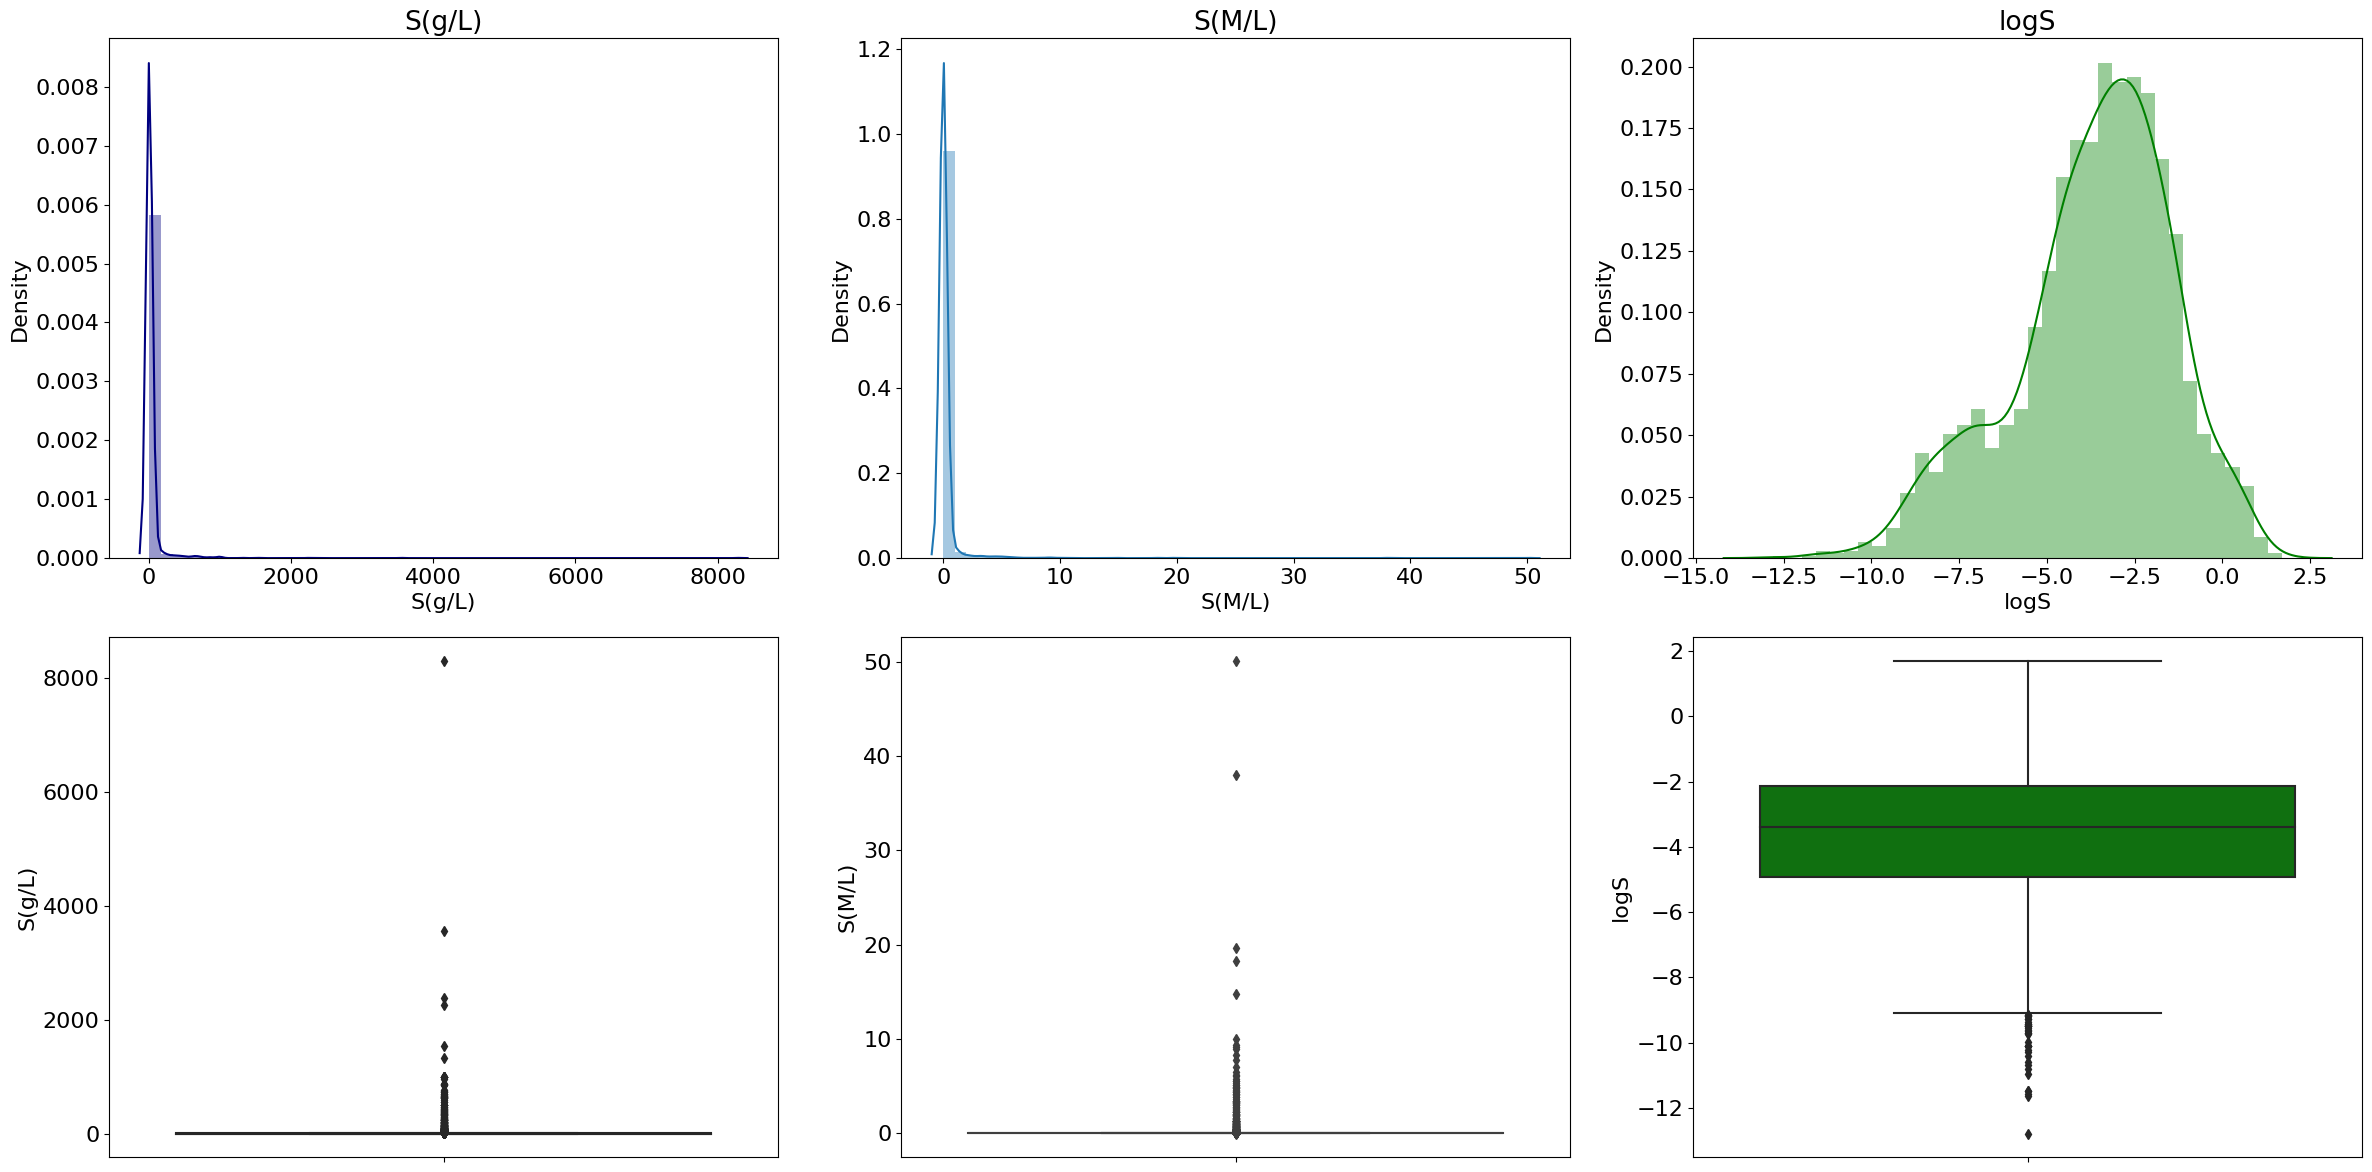

In [461]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
plt.rc('font', size=16)

# Top row - Distribution plots
sns.distplot(solubility['S(g/L)'], ax=axes[0, 0], color='navy')
axes[0, 0].set_title('S(g/L)')

sns.distplot(solubility['S(M/L)'], ax=axes[0, 1])
axes[0, 1].set_title('S(M/L)')

sns.distplot(solubility['logS'], ax=axes[0, 2], color='green')
axes[0, 2].set_title('logS')

# Bottom row - Boxplots
sns.boxplot(y=solubility['S(g/L)'], ax=axes[1, 0], color='navy')
sns.boxplot(y=solubility['S(M/L)'], ax=axes[1, 1])
sns.boxplot(y=solubility['logS'], ax=axes[1, 2],color='green')

plt.tight_layout()
plt.show()


We can see that the distributions of the absolute value of solubility ( in g/L and M/L) are not normal.
We will use the logarithmic solubility (logS) as the target variable as its distribution is closer than normal (although looks rather bimodal) as compared to
the distributions of the absolute solubility values.

We can drop absolute columns containing absolute solubilities.

In [462]:
solubility.drop(columns=['S(g/L)','S(M/L)'], inplace=True)

### Other variables

In [463]:
solubility.describe()

,Molecular weight,"Tmp, C",pK1,pK2,pK3,f(ui),logS,logP
count,2615.000000,2352.000000,1383.000000,418.000000,75.000000,2607.000000,2615.000000,2615.000000
mean,271.328894,146.791029,5.200087,7.639426,9.446000,0.909827,-3.694956,2.588091
std,112.042744,74.713022,2.933737,2.613471,2.540654,0.237226,2.275906,2.322828
min,59.068000,25.500000,-3.660000,1.400000,3.910000,0.000000,-12.790000,-13.975000
25%,194.615000,88.000000,2.955000,5.355000,7.835000,0.990000,-4.930000,1.055500
50%,261.000000,136.250000,4.760000,7.885000,9.610000,1.000000,-3.380000,2.344000
75%,327.000000,194.850000,7.700000,9.595000,10.720000,1.000000,-2.120000,3.892500
max,1300.000000,485.000000,14.400000,14.600000,17.400000,1.000000,1.700000,16.795000


#### Molecular weight

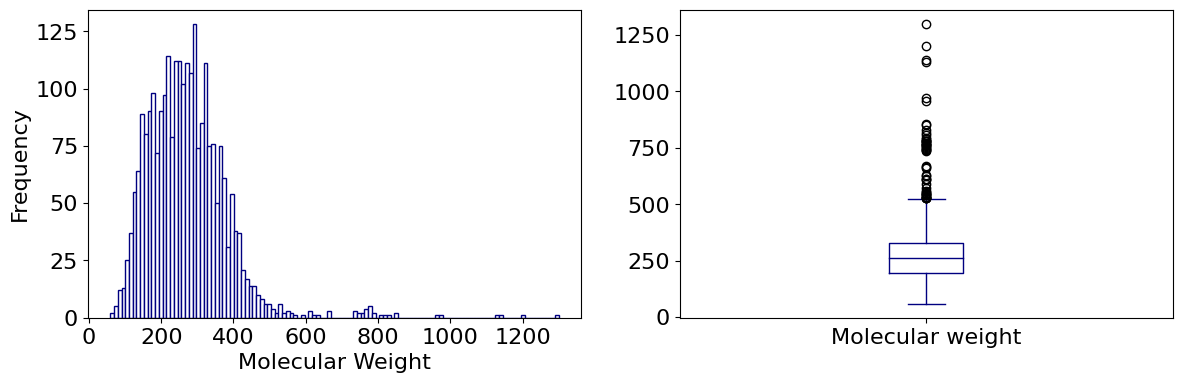

In [464]:
plt.figure(1)
plt.subplot(121)
plt.hist(solubility['Molecular weight'],bins=120,edgecolor='navy',color='white')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.subplot(122)
solubility['Molecular weight'].plot.box(figsize=(14,4),color='navy')
plt.show()

Let's take a look at what kind of molecules have suspiciously high molecular masses over 700.

In [465]:
print(solubility.loc[solubility['Molecular weight'].nlargest(10).index][['smiles','name']].values)

[['OCC1OC2OC3C(O)C(O)C(OC3CO)OC4C(O)C(O)C(OC4CO)OC5C(O)C(O)C(OC5CO)OC6C(O)C(O)C(OC6CO)OC7C(O)C(O)C(OC7CO)OC8C(O)C(O)C(OC8CO)OC9C(O)C(O)C(OC9CO)OC1C(O)C2O'
  'gamma-CYCLODEXTRIN']
 ['CCC1NC(=O)C(C(O)C(C)C\\C=C\\C)N(C)C(=O)C(C(C)C)N(C)C(=O)C(CC(C)C)N(C)C(=O)C(CC(C)C)N(C)C(=O)C(C)NC(=O)C(C)NC(=O)C(CC(C)C)N(C)C(=O)C(NC(=O)C(CC(C)C)N(C)C(=O)CN(C)C1=O)C(C)C'
  'CYCLOSPORIN  A']
 ['OC(=O)C1=C(I)C(=C(I)C=C1I)NC(=O)CCCCC(=O)NC2=C(I)C=C(I)C(=C2I)C(O)=O'
  'IODIPAMIDE;  ADIPIODONE']
 ['OCC1OC2OC3C(O)C(O)C(OC3CO)OC4C(O)C(O)C(OC4CO)OC5C(O)C(O)C(OC5CO)OC6C(O)C(O)C(OC6CO)OC7C(O)C(O)C(OC7CO)OC8C(O)C(O)C(OC8CO)OC1C(O)C2O'
  'beta-CYCLODEXTRIN;  BETADEX']
 ['OCC1OC2OC3C(O)C(O)C(OC3CO)OC4C(O)C(O)C(OC4CO)OC5C(O)C(O)C(OC5CO)OC6C(O)C(O)C(OC6CO)OC7C(O)C(O)C(OC7CO)OC1C(O)C2O'
  'alpha-CYCLODEXTRIN;  ALFADEX']
 ['BrC1=C(Br)C(=C(OC2=C(Br)C(=C(Br)C(=C2Br)Br)Br)C(=C1Br)Br)Br'
  'DECABROMODIPHENYL  ETHER']
 ['CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(=O)C4=CC=CC=C4)C5(O)CC(OC(=O)C(O)C(NC(=O)C6=CC=CC=C6)C7=CC=C

Those are indeed large molecules and they certainly would have high molecular weights.
So we can conclude that molecular weight data looks consistent and the outliers seem meaningful.

#### Melting point (Tmp, C)

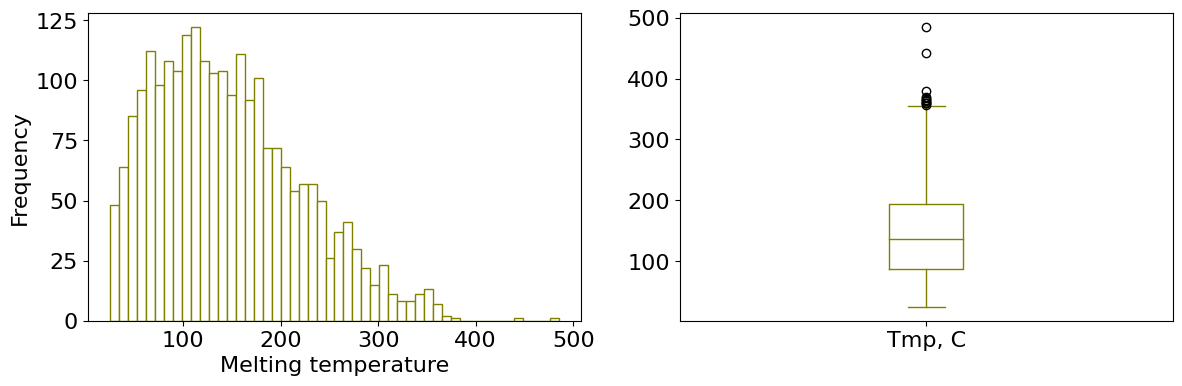

In [466]:
plt.figure(1)
plt.subplot(121)
plt.hist(solubility['Tmp, C'],edgecolor='olive',color='white',bins=50)
plt.xlabel('Melting temperature')
plt.ylabel('Frequency')
plt.subplot(122)
solubility['Tmp, C'].plot.box(figsize=(14,4),color='olive')
plt.show()

The distribution of the melting point temperatures is right-skewed with some outliers.

#### Octanol-water partitioning coefficient

The octanol-water partitioning coefficient (P) describes the distribution of the substance between aqueous (polar) and 
n-octanol (non-polar) solvents and is defined by the relation of the substance concentration in water and in n-octanol.

Let us visualize the natural logarithm of the partitioning coefficient (log(P)) of the substances in our data set.

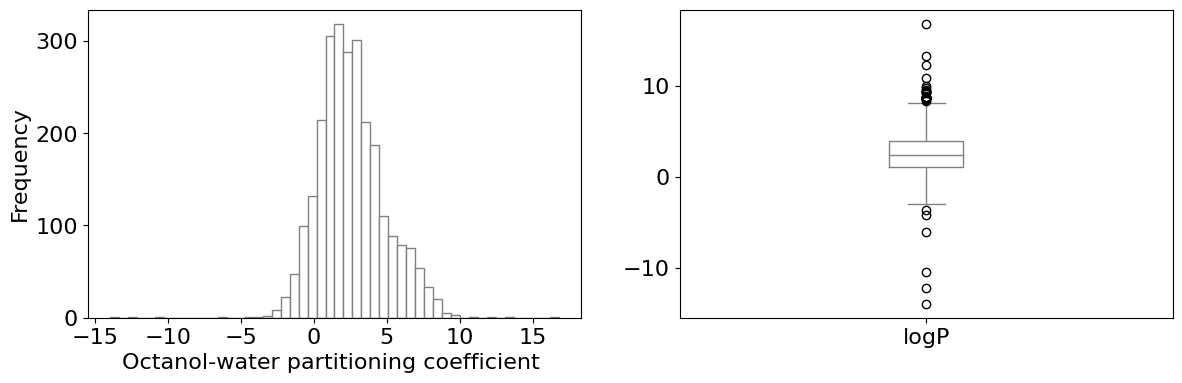

In [467]:
plt.figure(1)
plt.subplot(121)
plt.hist(solubility['logP'],edgecolor='grey',color='white',bins=50)
plt.xlabel('Octanol-water partitioning coefficient ')
plt.ylabel('Frequency')
plt.subplot(122)
solubility['logP'].plot.box(figsize=(14,4),color='grey')
plt.show()

The distribution of octanol-water partitioning coefficients contains some extreme outliers. We will later decide if we want to treat them.

#### Dissociation constants

Dissociation constant (K) define the extent to which a molecule can dissciate into ions in water.
K1 is the constant for the first step dissociation from neutral molecule to one cation and one anion.
K2 is the constant for the second step dissociation from an ion formed in the first step to another cation and anion.
K3 is the constant for the third step dissociation.

pK1, pK2 and pK3 are the negative logarithms of the dissociation constants (pK=-logK).

Most of the molecule have only one step of dissociation.
Let us visualize the distributions of the constants.

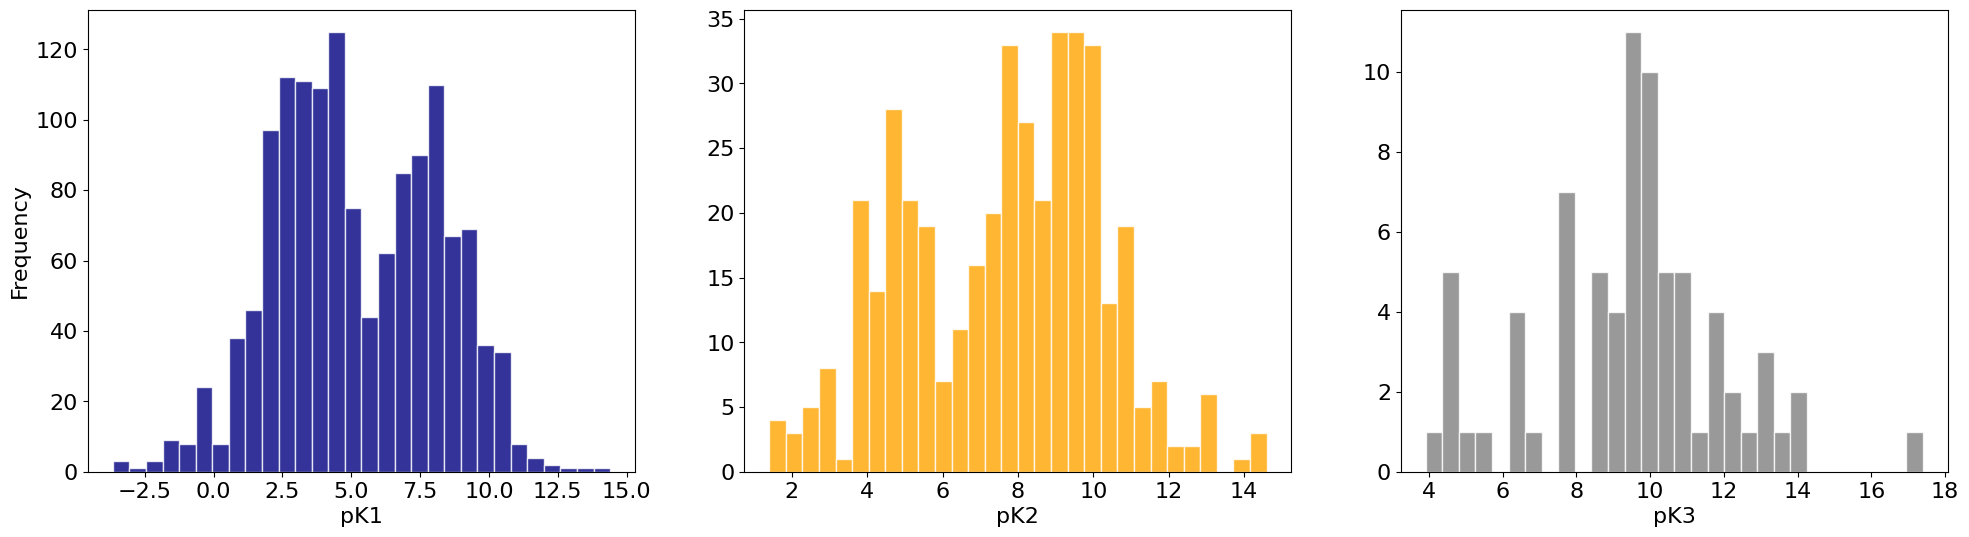

In [468]:
plt.figure(figsize=(24,6)) 
plt.rc('font', size=16)
plt.subplot(131)
plt.hist(solubility['pK1'],color='navy',edgecolor='white',bins=30,alpha=0.8)
plt.ylabel('Frequency')
plt.xlabel('pK1')
plt.subplot(132)
plt.hist(solubility['pK2'],color='orange',edgecolor='white',bins=30,alpha=0.8)
plt.xlabel('pK2')
plt.subplot(133)
plt.hist(solubility['pK3'],color='grey',edgecolor='white',bins=30,alpha=0.8)
plt.xlabel('pK3')
plt.show()

Remember that the columns with pK1, pK2 and pK3 values contained many missing values.
Let's take a better look at this.

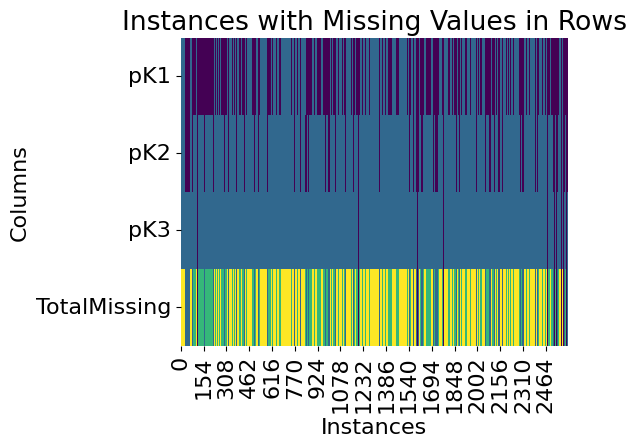

In [469]:
# Select columns with missing values
selected_columns = ['pK1', 'pK2', 'pK3']  # Replace with your column names

missing_values_matrix = solubility[selected_columns].isnull().astype(int)

missing_values_matrix['TotalMissing'] = missing_values_matrix.sum(axis=1)

plt.figure(figsize=(5, 4))
sns.heatmap(missing_values_matrix.T, cmap='viridis', cbar=False)
plt.xlabel('Instances')
plt.ylabel('Columns')
plt.title(f'Instances with Missing Values in Rows')
plt.show()

It looks like pK2 and pK3 are usually missing for a molecule with missing pK1 value.
We will drop pK3 and pK2 columns and we will impute pK1 with a machine learning model.

In [470]:
solubility.drop(columns=['pK2','pK3'], inplace=True)

### Un-ionized fraction

Text(0.5, 0, 'f(ui)')

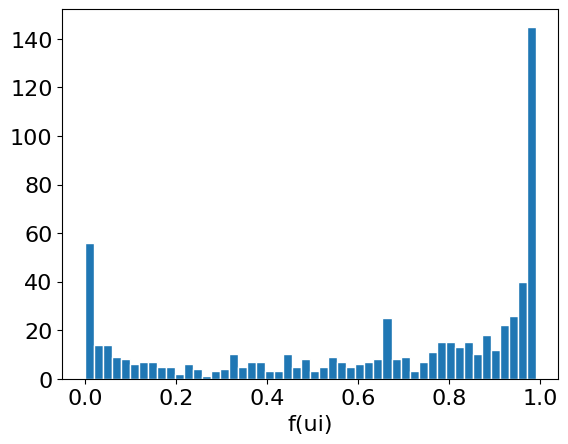

In [471]:
plt.hist(solubility['f(ui)'][solubility['f(ui)']<1],bins=50,edgecolor='white')
plt.xlabel('f(ui)')

For most of the molecules f(ui)=1 (the un-ionized fraction = 1) so they are entirely in un-ionized form.

### Bivariate exploration

We can make several hypothesis about the relationship between certain physiochemical qualities of a substance with
the substance solubility in water. For example:
    
1.There should be a relationship between the octanol-water partinioning coefficient and the solubility of a substance.
  Because one can assume that the higher is the solubility in water, the higher fraction of a sabstance would be in water
  rather than in organic octanol. And the higher the fraction in octanol the lower should be the solubility in water.
  So the higher is the partitioning coefficient the lower is the solubility.
  
2.A volume-related term (molecular polarizability α) was experimentally found to have an essential negative contribution 
  to solubility. The lower polarizability the higher solubility in polar water.
 
3.Water is a polar solvent so one can assume that the higher unionized fraction f(ui) the lower solubility in polar 
   water   solvent

4.One can also assume that the higher molecular weight the lower solubility because it is more difficult for a large molecule
  to dissolve.

5.The higher dissociation constants the higher solubility.
    
Let us make the pairplots with logS vs. physiochemical variable which will help us to explore all these hypothesis.

<Figure size 200x2500 with 0 Axes>

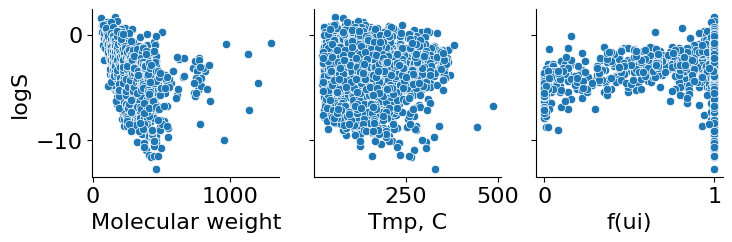

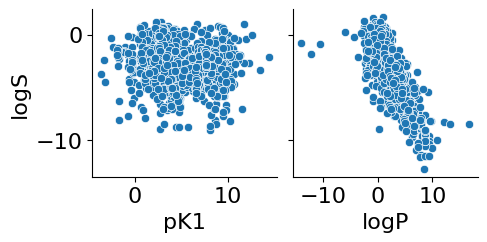

In [472]:
plt.figure(figsize=(2, 25))
sns.pairplot(data=solubility,
                  x_vars= ['Molecular weight', 'Tmp, C','f(ui)'],
                  y_vars=['logS'])
sns.pairplot(data=solubility,
                  x_vars= ['pK1', 'logP'],
                  y_vars=['logS'])
plt.show()

From the pairplots we can infer the following information:
    
- For the molecules with the molecular weight below 500, logS overally decreases with the increment in molecular wight.
  For the molecules with higher moleculatr weight there is no clear trend in relationship between solubility and molecular     weight.

- There is no clear trend in the relationship between logS and melting temperature (Tmp, C), dissociation constant (pK1), the un-ionized fractio (f(ui)).

- There seems to be a strong negative linear relationship between logS and the octanol-water partitioning coefficient logP.

### Correlation heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

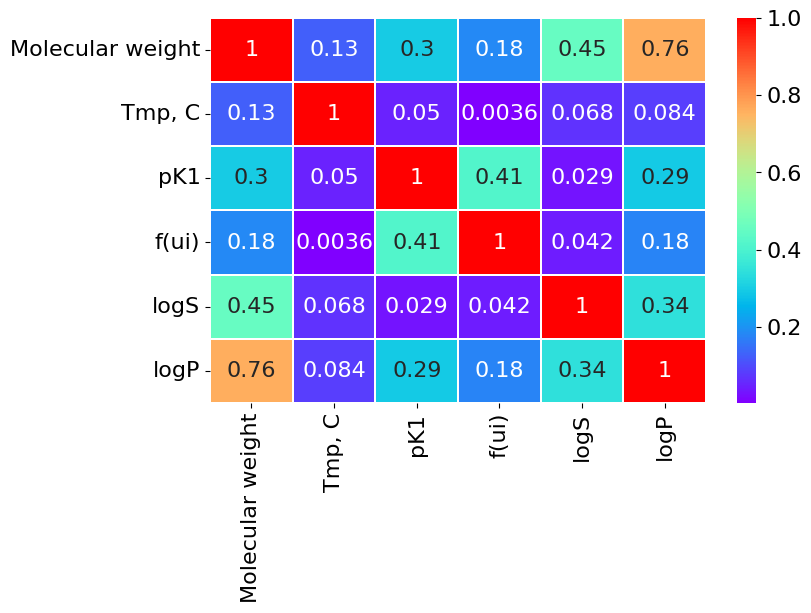

In [473]:
plt.figure(figsize=(8, 5))
corr = solubility.copy().drop(['smiles','name'],axis=1).apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr,annot=True, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.3, cmap="rainbow")

We can infer from the correlation matrix plot that solubility is correlated with molecular wight and
logP. We can also infer that logP is corellated with molecular weight.

Now, let us transform the data and generate new features that we can use for predictive modelling.

## Missing values treatment

In [474]:
data=solubility.copy()

In [475]:
data.isnull().sum()

smiles                 0
name                   0
Molecular weight       0
Tmp, C               263
pK1                 1232
f(ui)                  8
logS                   0
logP                   0
dtype: int64

There are missing values for the melting point variable (Tmp, C), the dissociation constant variable(pK1) and
the variable that defines the un-ionization fraction  (f(ui)).

On one hand, pK1 variabe showed some correlation with other variables like molecular mass and f(ui). We will impute missing values of pK1 values with a Ridge regression.

On the other hand, missing pK1 value can mean that it was not measured because the substance has low solubility in water.
In order to retain this information about instances with missing pK1 values, we will create, we can create a new feature (pK1_NA) which will indicate wheather the substance had a missing dissociation constant value.

Additionally, we will impute f(ui) and Tmp, C values with their corresponding median values.

In [476]:
data['f(ui)'].fillna(data['f(ui)'].median(),inplace=True)
data['Tmp, C'].fillna(data['Tmp, C'].median(),inplace=True)

**pK1_NA feature**

In [477]:
condition_pk=(data['pK1'].isna())
data['pK1_NA']=np.where(condition_pk,1,0)

In [478]:
print(data['pK1_NA'].value_counts())

0    1383
1    1232
Name: pK1_NA, dtype: int64


In [479]:
# Impute pK1 with the min value
#data['pK1'].fillna(data['pK1'].min(),inplace=True)

In [480]:
#data.columns

In [481]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   smiles            2615 non-null   object 
 1   name              2615 non-null   object 
 2   Molecular weight  2615 non-null   float64
 3   Tmp, C            2615 non-null   float64
 4   pK1               1383 non-null   float64
 5   f(ui)             2615 non-null   float64
 6   logS              2615 non-null   float64
 7   logP              2615 non-null   float64
 8   pK1_NA            2615 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 184.0+ KB


In [482]:
df=data.copy()

# Selecting columns for imputation and transformation
features = ['Molecular weight', 'Tmp, C', 'f(ui)', 'logP', 'pK1_NA']
target = 'pK1'

# Define the transformer pipeline
transformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), features),
        ('scaler', StandardScaler(), features)
    ],
    remainder='passthrough'
)

# Ridge Regression model
ridge = Ridge(alpha=1.0)

# Create the pipeline
pipeline = Pipeline([
    ('transformer', transformer),
    ('ridge', ridge)
])

# Separate data into features and target for training
X_train = df.drop(columns=['smiles', 'name', 'logS']).dropna(subset=[target])
y_train = X_train.pop(target)

# Fit the pipeline on non-null values of pK1 and corresponding features
pipeline.fit(X_train, y_train)

# Predict missing values of pK1
X_missing = df[df[target].isnull()].drop(columns=['smiles', 'name', 'logS'])
predicted_pK1 = pipeline.predict(X_missing)

# Fill missing values in the DataFrame
df.loc[df[target].isnull(), target] = predicted_pK1

df.head()

,smiles,name,Molecular weight,"Tmp, C",pK1,f(ui),logS,logP,pK1_NA
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,56.0,5.224921,1.0,-0.40,1.108,1
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,35.0,5.212114,1.0,-1.00,1.013,1
2,C1OCOCO1,"1,3,5-TRIOXANE",90.079,64.0,5.010456,1.0,0.29,-0.446,1
3,CC(N)=O,ACETAMIDE,59.068,80.0,4.883871,1.0,1.58,-0.832,1
4,CC(O)CNCC(C)O,BIS(2-HYDROXYPROPYL)AMINE,133.191,44.5,8.970000,1.0,0.81,-0.540,0


**Check for missing values**

In [483]:
df.isnull().sum()

smiles              0
name                0
Molecular weight    0
Tmp, C              0
pK1                 0
f(ui)               0
logS                0
logP                0
pK1_NA              0
dtype: int64

In [484]:
df.shape

(2615, 9)

In [485]:
data_cleaned=df.copy()
data_cleaned.to_csv('data_cleaned.csv',index=False)

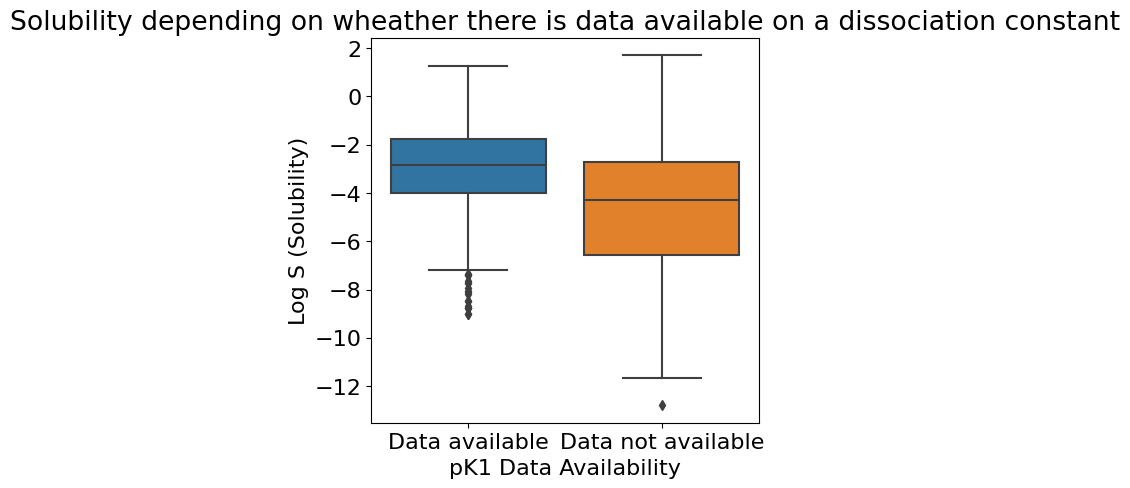

In [486]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='pK1_NA', y='logS', data=df)
plt.title('Solubility depending on wheather there is data available on a dissociation constant')
plt.ylabel('Log S (Solubility)')
plt.xlabel('pK1 Data Availability')
plt.xticks([0, 1], ['Data available', 'Data not available']) 
plt.show()


It seems like the median solubility for the molecules with available dissociation contants is indeed higher than in the case of the molecule with no experimental dissociation data available. 

## More feature engineering

Now, we will use the information about the chemical structure of molecules available through the variable Formula to
generate new features that can affect aqueous solubility of a molecule.

### Charge

One can assume that charged molcules should have higher solubility in water since water is a polar sovent.
Charged molecules contain regions with positive charge and an equal amount of negatively charged regions in order to
resulting charge to be 0.

In [487]:
charge=[]

for i in range(2615):
    if df['smiles'][i].find('+')!=-1:
        charge.append(1)
    elif df['smiles'][i].find('-')!=-1:
        charge.append(-1)
    else:
        charge.append(0)
df['charge']=charge
print('The number of charged and uncharged molecules:')
print(df['charge'].value_counts())


The number of charged and uncharged molecules:
0    2430
1     185
Name: charge, dtype: int64


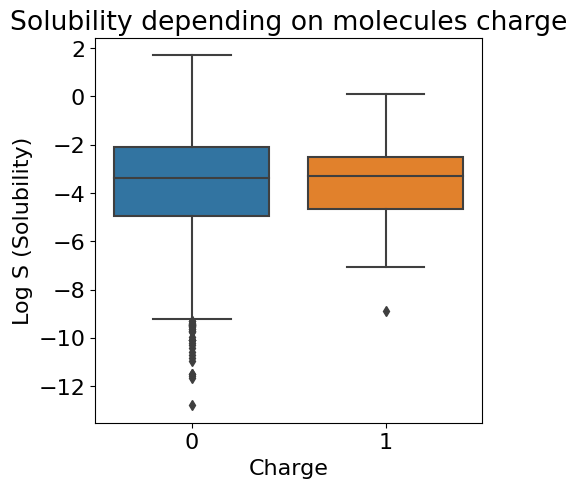

In [488]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='charge', y='logS', data=df)
plt.title('Solubility depending on molecules charge')
plt.ylabel('Log S (Solubility)')
plt.xlabel('Charge')
plt.show()

It looks like substances' charge does not affect solubility much.

### Double bonds

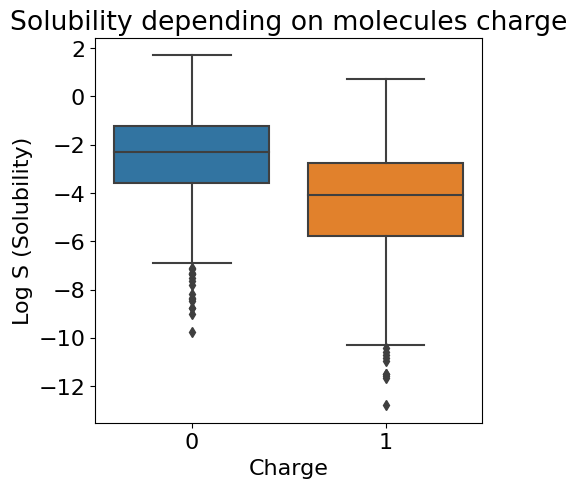

In [489]:
double_bonds=[]

for i in range(2615):
    if df['smiles'][i].count('=')>4:
        double_bonds.append(1)
    else:
        double_bonds.append(0)
        
df['many_double_bonds']=double_bonds

plt.figure(figsize=(5, 5))
sns.boxplot(x='many_double_bonds', y='logS', data=df)
plt.title('Solubility depending on molecules charge')
plt.ylabel('Log S (Solubility)')
plt.xlabel('Charge')
plt.show()

We can infer that among the molecules with 5 and more double bonds, the proportion of soluble molecules is lower as compared 
to molecules with lower amount of double bonds.

In [490]:
def get_all_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    if mol is not None:
        atoms = mol.GetAtoms()

        for atom in atoms:
            atom_symbols.add(atom.GetSymbol())

In [491]:
#Check inconsisten smiles and correct them
smiles_list=df['smiles'].tolist()

for smiles in smiles_list: 
    
    try:
        get_all_atoms(smiles)
    except:
        print(smiles)

S=C(\[SH]=N/[N]#N)C(=S)/[SH]=N/[N]#N


In [492]:
df[df['smiles']=='S=C(\[SH]=N/[N]#N)C(=S)/[SH]=N/[N]#N']

,smiles,name,Molecular weight,"Tmp, C",pK1,f(ui),logS,logP,pK1_NA,charge,many_double_bonds
1617,S=C(\[SH]=N/[N]#N)C(=S)/[SH]=N/[N]#N,AZIDODICARBONDISULFIDE,236.0,136.25,5.787056,1.0,-2.9,4.114,1,0,0


In [493]:
#Change the error for a consistent smiles value
df.loc[1617, 'smiles'] ='N#N=N-C(=S)SSC(=S)N=N#N'

In [494]:
# set that used to store all unique atom symbols
atom_symbols = set()

# apply the above func to all compound smiles in dataframe
df['smiles'].apply(lambda x: get_all_atoms(x))

print("Unique atom symbols:", atom_symbols)
print(len(atom_symbols)) # there are 40 unique atom symbols, including hydrogen

hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]

Unique atom symbols: {'N', 'O', 'P', 'F', 'C', 'I', 'Cl', 'Br', 'S', 'H'}
10


The substances in the data set contain only these 10 elements.

### Atom symbols in all the bonds

In [495]:
def get_atoms(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_atom_vector = np.zeros(10)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_symbol_vector = np.array([1 if s == atom1.GetSymbol() else 0 for s in atom_symbols]) # 10-length one-hot vector

        sum_atom_vector+=atom_symbol_vector
        # Create one-hot encoded vectors for atom2
        atom_symbol_vector = np.array([1 if s == atom2.GetSymbol() else 0 for s in atom_symbols]) # 10-length one-hot vector
      
        sum_atom_vector+=atom_symbol_vector

    return np.round(sum_atom_vector).astype(int)#10 length resulting vector


In [496]:
initial_columns=df.columns.tolist()
initial_columns

['smiles',
 'name',
 'Molecular weight',
 'Tmp, C',
 'pK1',
 'f(ui)',
 'logS',
 'logP',
 'pK1_NA',
 'charge',
 'many_double_bonds']

In [497]:
df['atom_features'] = df['smiles'].apply(lambda x: get_atoms(x))

atoms_list=[s for s in atom_symbols]

# Function to split lists into separate columns
def split_list_to_columns(col_name,row):
    return pd.Series(row[col_name])

col_name='atom_features'

# Split the "features" column and keep other columns
df_atom_symbol = df.join(df.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_atom_symbol = df_atom_symbol.drop(col_name, axis=1)

df_atom_symbol.columns = initial_columns+atoms_list 
# Print the resulting DataFrame
df_atom_symbol.head(2)

,smiles,name,Molecular weight,"Tmp, C",pK1,f(ui),logS,logP,pK1_NA,charge,...,N,O,P,F,C,I,Cl,Br,S,H
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,56.0,5.224921,1.0,-0.4,1.108,1,0,...,0,2,0,0,20,0,0,0,0,12
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,35.0,5.212114,1.0,-1.0,1.013,1,0,...,2,0,0,0,6,0,0,0,1,3


### Atom degrees in all the bonds

In [498]:
def get_atom_degrees(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_degree_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)]) # 7-length one-hot vector

        sum_degree_vector+=atom_degree_vector
        # Create one-hot encoded vectors for atom2
        atom_degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])# 7-length one-hot vector
      
        sum_degree_vector+=atom_degree_vector

    return np.round(sum_degree_vector).astype(int) # 7-length vector

In [499]:
initial_columns=df_atom_symbol.columns.tolist()
df_atom_symbol['degree_features'] = df_atom_symbol['smiles'].apply(lambda x: get_atom_degrees(x))
atom_degree_labels=['atoms_degree_0','atoms_degree_1','atoms_degree_2','atoms_degree_3',
                    'atoms_degree_4','atoms_degree_5','atoms_degree_6']

In [500]:
col_name='degree_features'

# Split the "features" column and keep other columns
df_atom_degree = df_atom_symbol.join(df_atom_symbol.apply(lambda row: split_list_to_columns(col_name,row), axis=1))


df_atom_degree = df_atom_degree.drop(col_name, axis=1)
df_atom_degree.columns = initial_columns+atom_degree_labels 

# Print the resulting DataFrame
df_atom_degree.head(2)

,smiles,name,Molecular weight,"Tmp, C",pK1,f(ui),logS,logP,pK1_NA,charge,...,Br,S,H,atoms_degree_0,atoms_degree_1,atoms_degree_2,atoms_degree_3,atoms_degree_4,atoms_degree_5,atoms_degree_6
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,56.0,5.224921,1.0,-0.4,1.108,1,0,...,0,0,12,0,12,2,0,20,0,0
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,35.0,5.212114,1.0,-1.0,1.013,1,0,...,0,1,3,0,4,4,0,4,0,0


### Atoms valances across all bonds

In [501]:
def get_atom_valences(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_valence_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # 7-length one-hot vector

        sum_valence_vector+=atom_valence_vector
        # Create one-hot encoded vectors for atom2
        atom_valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)]) # 7-length one-hot vector
      
        sum_valence_vector+=atom_valence_vector

    return np.round(sum_valence_vector).astype(int) # 7-length vector

In [502]:
initial_columns=df_atom_degree.columns.tolist()
df_atom_degree['valence_features'] = df_atom_symbol['smiles'].apply(lambda x: get_atom_valences(x))
atom_valence_labels=['atoms_valence_0','atoms_valence_1','atoms_valence_2','atoms_valence_3',
                    'atoms_valence_4','atoms_valence_5','atoms_valence_6']

In [503]:
col_name='valence_features'

# Split the "features" column and keep other columns
df_atom_valence = df_atom_degree.join(df_atom_degree.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_atom_valence = df_atom_valence.drop(col_name, axis=1)

df_atom_valence.columns = initial_columns+atom_valence_labels  
df_atom_valence.head(2)

,smiles,name,Molecular weight,"Tmp, C",pK1,f(ui),logS,logP,pK1_NA,charge,...,atoms_degree_4,atoms_degree_5,atoms_degree_6,atoms_valence_0,atoms_valence_1,atoms_valence_2,atoms_valence_3,atoms_valence_4,atoms_valence_5,atoms_valence_6
0,CC(C)(C)CO,"NEOPENTYL ALCOHOL; 2,2-DIMETHYL-1-PROPANOL",88.150,56.0,5.224921,1.0,-0.4,1.108,1,0,...,20,0,0,0,12,2,0,20,0,0
1,CN=C=S,METHYL ISOTHIOCYANATE,73.119,35.0,5.212114,1.0,-1.0,1.013,1,0,...,4,0,0,0,3,1,2,6,0,0


### Atoms hybridization across all bonds

In [504]:
def get_atom_hybridization(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_hybrid_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_hybrid_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations])  # 7-length one-hot vector

        sum_hybrid_vector+=atom_hybrid_vector
        # Create one-hot encoded vectors for atom2
        atom_hybrid_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
      
        sum_hybrid_vector+=atom_hybrid_vector

    return np.round(sum_hybrid_vector).astype(int) # 7-length vector

In [505]:
initial_columns=df_atom_valence.columns.tolist()
df_atom_valence['hybridization_features'] = df_atom_valence['smiles'].apply(lambda x: get_atom_hybridization(x))
hybridization_labels=['atom_hybridization_S','atom_hybridization_SP','atom_hybridization_SP2',
                      'atom_hybridization_SP3','atom_hybridization_SP3D','atom_hybridization_SP3D2',
                      'atom_hybridization_UNSPECIFIED']

In [506]:
col_name='hybridization_features'

# Split the "features" column and keep other columns
df_atom_hybridization = df_atom_valence.join(df_atom_valence.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_atom_hybridization = df_atom_hybridization.drop(col_name, axis=1)


df_atom_hybridization.columns = initial_columns+hybridization_labels 


### Atoms aromaticity across all bonds

In [507]:
def get_atom_aromaticity(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_aromatic_vector = np.zeros(1)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_aromatic_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

        sum_aromatic_vector+=atom_aromatic_vector
        # Create one-hot encoded vectors for atom2
        atom_aromatic_vector = np.array([1 if atom2.GetIsAromatic() else 0])# 1-length one-hot vector
      
        sum_aromatic_vector+=atom_aromatic_vector

    return np.round(sum_aromatic_vector).astype(int)[0] # number 0 or 1

In [508]:
df_atom_hybridization['aromatic_atoms'] = df_atom_hybridization['smiles'].apply(lambda x: get_atom_aromaticity(x))
df_atom_aromaticity=df_atom_hybridization.copy()

### Bond types

In [509]:
def get_bond_types(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_bond_type_vector = np.zeros(5)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        
        bond_type = bond.GetBondType().name
        
        bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])# 5-length one-hote vector
        
        sum_bond_type_vector+=bond_type_vector

    return np.round(sum_bond_type_vector).astype(int) 

In [510]:
initial_columns=df_atom_aromaticity.columns.tolist()
df_atom_aromaticity['bond_type_features'] = df_atom_aromaticity['smiles'].apply(lambda x: get_bond_types(x))
bond_type_labels=['single_bonds','double_bonds','triple_bonds','aromatic_bonds','zero_bonds']

In [511]:
col_name='bond_type_features'

# Split the "features" column and keep other columns
df_bond_type = df_atom_aromaticity.join(df_atom_aromaticity.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_bond_type = df_bond_type.drop(col_name, axis=1)

df_bond_type.columns = initial_columns+bond_type_labels 

### Conjugated bonds

In [512]:
def is_conjugated(smiles):
    
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Get all bonds in the molecule
    bonds = mol.GetBonds()
    
    sum_conjugated = np.zeros(1)
    
    for bond in bonds:
        
        is_conjugated=1 if bond.GetIsConjugated() else 0
        conjugation_vector = np.array([is_conjugated])
        
        sum_conjugated+=conjugation_vector
        
    return np.round(sum_conjugated).astype(int)[0]

In [513]:
df_bond_type['conjugated_bonds'] = df_bond_type['smiles'].apply(lambda x: is_conjugated(x))
df_conjugated_bonds=df_bond_type.copy()

### Bonds in ring

In [514]:
def is_in_ring(smiles):
    
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Get all bonds in the molecule
    bonds = mol.GetBonds()
    
    sum_in_ring = np.zeros(1)
    
    for bond in bonds:
        
        is_in_ring=1 if bond.IsInRing() else 0
        in_ring_vector = np.array([is_in_ring])
        
        sum_in_ring+=in_ring_vector
        
    return np.round(sum_in_ring).astype(int)[0]

In [515]:
df_conjugated_bonds['bonds_in_ring'] = df_conjugated_bonds['smiles'].apply(lambda x: is_in_ring(x))
df_bonds_in_ring=df_conjugated_bonds.copy()

### Bond chirality

The bond.GetStereo() method typically returns one of the following values:

Chem.rdchem.BondStereo.STEREONONE: This indicates that the bond has no defined stereochemistry, meaning there is no specific spatial arrangement of substituents around the bond that results in different stereoisomers.

Chem.rdchem.BondStereo.STEREOANY: This indicates that the bond is considered a stereo bond, but its stereochemistry is not specified. It means that the bond could potentially have stereoisomers, but their configurations are not defined or are flexible.

Chem.rdchem.BondStereo.STEREOZ and Chem.rdchem.BondStereo.STEREOE: These values are used to specify the stereochemistry of double bonds (alkene bonds).

STEREOZ indicates a "cis" configuration where substituents on the same side of the double bond. STEREOE indicates a "trans" configuration where substituents are on opposite sides of the double bond.

In [516]:
def get_bond_chirality(smiles):
    
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Get all bonds in the molecule
    bonds = mol.GetBonds()
    
    sum_chirality = np.zeros(4)
    
    for bond in bonds:
        
        # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
        chirality = bond.GetStereo()
        
        chirality_vector=np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])
        
        sum_chirality+=chirality_vector
        
    return np.round(sum_chirality).astype(int)

In [517]:
initial_columns=df_bonds_in_ring.columns.tolist()
df_bonds_in_ring['chirality_features'] = df_bonds_in_ring['smiles'].apply(lambda x: get_bond_chirality(x))
chirality_labels=['chirality_none','chirality_any','chirality_z','chirality_e']

In [518]:
col_name='chirality_features'

# Split the "features" column and keep other columns
df_bond_chirality = df_bonds_in_ring.join(df_bonds_in_ring.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_bond_chirality= df_bond_chirality.drop(col_name, axis=1)

df_bond_chirality.columns = initial_columns+chirality_labels  


### Number of atoms

In [519]:
def get_n_atoms(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_atoms=mol.GetNumAtoms()
    
    return n_atoms 

In [520]:
df_final=df_bond_chirality.copy()
df_final['n_atoms']=df_final['smiles'].apply(lambda x: get_n_atoms(x))

### Number of bonds

In [521]:
def get_n_bonds(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_bonds=mol.GetNumBonds()
    
    return n_bonds

In [522]:
df_final['n_bonds']=df_final['smiles'].apply(lambda x: get_n_bonds(x))

### Number of rings

'Chem.GetSymmSSSR(mol): This function, GetSymmSSSR, is used to identify and retrieve the symmetrically distinct smallest set of smallest rings in a molecule (mol). SSSR refers to a collection of rings in a molecule where each ring is as small as possible and where no two rings share an identical set of atoms.

len(...): This is the Python len function, which is used to determine the length (i.e., the number of elements) of a given sequence or container, in this case, the list of symmetrically distinct rings returned by Chem.GetSymmSSSR(mol).

So, len(Chem.GetSymmSSSR(mol)) calculates and returns the count of symmetrically distinct rings in the molecule mol. This information can be useful for understanding the molecular structure, aromaticity, and other properties of the molecule, as rings play a significant role in organic chemistry and chemical analysis.

In [523]:
def get_n_rings(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_rings=len(Chem.GetSymmSSSR(mol))
    
    return n_rings

In [524]:
df_final['n_rings']=df_final['smiles'].apply(lambda x: get_n_rings(x))

## Solubility prediction

In [525]:
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin

In [526]:
class DataFrameScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        scaled_data = self.scaler.transform(X)
        return pd.DataFrame(data=scaled_data, columns=X.columns)

In [527]:
df_final.columns

Index(['smiles', 'name', 'Molecular weight', 'Tmp, C', 'pK1', 'f(ui)', 'logS',
       'logP', 'pK1_NA', 'charge', 'many_double_bonds', 'N', 'O', 'P', 'F',
       'C', 'I', 'Cl', 'Br', 'S', 'H', 'atoms_degree_0', 'atoms_degree_1',
       'atoms_degree_2', 'atoms_degree_3', 'atoms_degree_4', 'atoms_degree_5',
       'atoms_degree_6', 'atoms_valence_0', 'atoms_valence_1',
       'atoms_valence_2', 'atoms_valence_3', 'atoms_valence_4',
       'atoms_valence_5', 'atoms_valence_6', 'atom_hybridization_S',
       'atom_hybridization_SP', 'atom_hybridization_SP2',
       'atom_hybridization_SP3', 'atom_hybridization_SP3D',
       'atom_hybridization_SP3D2', 'atom_hybridization_UNSPECIFIED',
       'aromatic_atoms', 'single_bonds', 'double_bonds', 'triple_bonds',
       'aromatic_bonds', 'zero_bonds', 'conjugated_bonds', 'bonds_in_ring',
       'chirality_none', 'chirality_any', 'chirality_z', 'chirality_e',
       'n_atoms', 'n_bonds', 'n_rings'],
      dtype='object')

### Train-test split

In [528]:
import random
random.seed(42)

scaler = DataFrameScaler()

feature_cols=['Molecular weight', 'Tmp, C', 'pK1', 'f(ui)',
       'logP', 'pK1_NA', 'charge', 'many_double_bonds', 'N', 'O', 'P', 'F', 'C',
       'I', 'Cl', 'Br', 'S', 'H', 'atoms_degree_0', 'atoms_degree_1',
       'atoms_degree_2', 'atoms_degree_3', 'atoms_degree_4', 'atoms_degree_5',
       'atoms_degree_6', 'atoms_valence_0', 'atoms_valence_1',
       'atoms_valence_2', 'atoms_valence_3', 'atoms_valence_4',
       'atoms_valence_5', 'atoms_valence_6', 'atom_hybridization_S',
       'atom_hybridization_SP', 'atom_hybridization_SP2',
       'atom_hybridization_SP3', 'atom_hybridization_SP3D',
       'atom_hybridization_SP3D2', 'atom_hybridization_UNSPECIFIED',
       'aromatic_atoms', 'single_bonds', 'double_bonds', 'triple_bonds',
       'aromatic_bonds', 'zero_bonds', 'conjugated_bonds', 'bonds_in_ring',
       'chirality_none', 'chirality_any', 'chirality_z', 'chirality_e',
       'n_atoms', 'n_bonds', 'n_rings']
    
X=df_final.copy()[feature_cols]
y=df_final.copy()['logS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

X_train_prep = scaler.fit_transform(X_train.copy())
X_test_prep = scaler.transform(X_test.copy())
X_all_prep = scaler.transform(X.copy())

y_all = y.copy()

print(f'Train/test sizes: {len(X_train)}/{len(X_test)}')

X_train_prep.head(5)

Train/test sizes: 2092/523


,Molecular weight,"Tmp, C",pK1,f(ui),logP,pK1_NA,charge,many_double_bonds,N,O,...,zero_bonds,conjugated_bonds,bonds_in_ring,chirality_none,chirality_any,chirality_z,chirality_e,n_atoms,n_bonds,n_rings
0,-0.239835,-1.465531,0.180750,0.385303,0.523691,1.062158,-0.27592,-1.312996,-0.950008,-0.179777,...,0.0,-0.893790,-0.746621,-0.239340,0.0,-0.098247,-0.121837,-0.193823,-0.241165,-0.706966
1,0.264787,-0.157755,0.017025,0.385303,-0.559166,1.062158,-0.27592,0.761617,0.366162,0.098811,...,0.0,0.770069,0.869616,0.490365,0.0,-0.098247,-0.121837,0.439440,0.487819,0.818535
2,3.603563,-0.154295,-0.167767,0.385303,-0.115669,-0.941480,-0.27592,0.761617,2.121054,1.213163,...,0.0,2.618802,1.839357,3.530800,0.0,-0.098247,-0.121837,3.542428,3.525255,1.581285
3,-0.500827,-0.060882,0.000112,0.385303,-0.168733,1.062158,-0.27592,0.761617,-0.950008,0.934575,...,0.0,0.954943,0.707992,-0.360957,0.0,-0.098247,-0.121837,-0.447128,-0.362663,0.818535
4,-0.389218,0.098265,1.949485,0.385303,0.496080,-0.941480,-0.27592,0.761617,-0.950008,0.098811,...,0.0,0.400323,0.223121,0.125512,0.0,-0.098247,-0.121837,0.122808,0.123327,0.055784


### Metrics

In [529]:
def mae(y, y_pred):
    if hasattr(y, 'index') and hasattr(y_pred, 'index'):
        assert list(y.index) == list(y_pred.index)
    return np.mean(np.absolute(y - y_pred))

def rmse(y, y_pred):
    if hasattr(y, 'index') and hasattr(y_pred, 'index'):
        assert list(y.index) == list(y_pred.index)
    return np.mean((y - y_pred) ** 2) ** 0.5

def run_crossvalidation(model, X, y, scoring_functions=(('mae', mae), ('rmse', rmse)),
                        random_seed=42, val_size=0.2, num_splits=5, verbose=False):

    num_folds = round(1/val_size)
    num_reps = round(num_splits/num_folds)
    fold_scores = pd.DataFrame()
    rkfold = RepeatedKFold(n_splits=num_folds, n_repeats=num_reps, random_state=random_seed)
    for i, (train_index, val_index) in enumerate(rkfold.split(X)):
        X_train_split, X_val_split = X.iloc[train_index], X.iloc[val_index]
        y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]
        model.fit(X_train_split, y_train_split)
        y_train_split_pred = model.predict(X_train_split)
        y_val_split_pred = model.predict(X_val_split)
        for name, scoring_f in scoring_functions:
            train_score = scoring_f(y_train_split, y_train_split_pred)
            val_score = scoring_f(y_val_split, y_val_split_pred)
            fold_scores.at[i, f'{name}_train'] = train_score
            fold_scores.at[i, f'{name}_val'] = val_score
            if verbose:
                print(f'Fold {i + 1} ({name}): \t Training score: {train_score}, \t Validation score: {val_score}')
    return fold_scores

crossval_scores_table = pd.DataFrame()
col_map = {
    'mae_train': 'MAE_train',
    'mae_val': 'MAE_val', 
    'rmse_train': 'RMSE_train',
    'rmse_val': 'RMSE_val', 
}

def crossval_scores(model, X, y, scoring_functions=(('mae', mae), ('rmse', rmse)),
                    random_seed=42, val_size=0.2, num_splits=5, verbose=False, show_table=True,show_scores=False):
    fold_scores = run_crossvalidation(model, X, y, scoring_functions, 
                                      random_seed, val_size, num_splits, verbose)
    model_name = str(type(model)).split(".")[-1].split("'")[0]
    for col in fold_scores.columns:
        crossval_scores_table.at[model_name, col_map[col]] = np.mean(fold_scores[col])
        crossval_scores_table.at[model_name, f's({col_map[col]})'] = np.std(fold_scores[col])
    
    if show_table:
        with pd.option_context('display.max_colwidth', None):
            display(crossval_scores_table)
     
    #return mean validation mae (capped)
    if show_scores==True:
        mean_mae=fold_scores['mae_val'].mean()
        return mean_mae

### Naive estimator

In [530]:
class MedianEstimator(BaseEstimator, RegressorMixin):
    __name__ = 'MedianEstimator'
    def fit(self, X, y):
        self.median_y_ = np.median(y)
    def predict(self, X):
        return np.ones(len(X))*self.median_y_

model_naive = MedianEstimator()

crossval_scores(model_naive, X_train_prep, y_train, show_table=True)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.7466,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648


### Linear Regression + Regularization

In [531]:
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()

In [532]:
crossval_scores(model_lin, X_train_prep, y_train, show_table=True)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.746600,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648
LinearRegression,0.704016,0.005676,0.740691,0.034058,0.939439,0.008173,1.109323,0.254537


In [533]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [534]:
from scipy.stats import uniform
# Ridge Regression Model
model_ridge = Ridge()

# Define a range of alpha values to search through
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0,20.0, 100]}  # Example alpha values

grid_search = GridSearchCV(estimator=model_ridge, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_prep, y_train)

best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f'Best alpha: {best_alpha}')
print(f'Best negative MSE: {best_score}')

Best alpha: 10.0
Best negative MSE: -0.9650398884496122


In [535]:
model_ridge = Ridge(alpha=10)
crossval_scores(model_ridge, X_train_prep, y_train, show_table=True)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.746600,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648
LinearRegression,0.704016,0.005676,0.740691,0.034058,0.939439,0.008173,1.109323,0.254537
Ridge,0.709223,0.006199,0.727202,0.024918,0.943744,0.008399,0.975877,0.030302


### Support vector regression

In [536]:
from sklearn.svm import SVR

In [537]:
distributions={
        'C': [1, 5, 10, 20, 40],
        'epsilon': [0.01, 0.02, 0.05, 0.1, 0.2]
    }

clf = RandomizedSearchCV(SVR(), distributions, random_state=42)
search = clf.fit(X_train_prep, y_train)
search.best_params_

{'epsilon': 0.1, 'C': 10}

In [538]:
model_svr = SVR(C=10, epsilon=0.1)
crossval_scores(model_svr, X_train_prep, y_train, show_table=True)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.746600,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648
LinearRegression,0.704016,0.005676,0.740691,0.034058,0.939439,0.008173,1.109323,0.254537
Ridge,0.709223,0.006199,0.727202,0.024918,0.943744,0.008399,0.975877,0.030302
SVR,0.339787,0.005631,0.601549,0.021975,0.543775,0.006982,0.872220,0.023669


### Random Forest regressor

In [539]:
from sklearn.ensemble import RandomForestRegressor


In [540]:
distributions={
        'random_state': [42], 
        'max_depth': [4, 6, 8, 10, 12, 14, 16],
        'max_leaf_nodes': [8, 16, 32, 64, 128, 256, 512, None], 
        'min_samples_split': [2, 4, 6, 8, 10, 12],
        'min_samples_leaf': [1, 3, 5, 10, 15, 20, 30],
       'n_estimators': [25, 50, 100, 200, 400],
    }

clf = RandomizedSearchCV(RandomForestRegressor(), distributions, random_state=42)
search = clf.fit(X_train_prep, y_train)
search.best_params_

{'random_state': 42,
 'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 256,
 'max_depth': 8}

In [541]:
model_rfr = RandomForestRegressor(random_state=42, max_depth=8, max_leaf_nodes=256, min_samples_split=8, 
                                  min_samples_leaf=1, n_estimators=50)
crossval_scores(model_rfr, X_train_prep, y_train, show_table=True)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.746600,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648
LinearRegression,0.704016,0.005676,0.740691,0.034058,0.939439,0.008173,1.109323,0.254537
Ridge,0.709223,0.006199,0.727202,0.024918,0.943744,0.008399,0.975877,0.030302
SVR,0.339787,0.005631,0.601549,0.021975,0.543775,0.006982,0.872220,0.023669
RandomForestRegressor,0.457398,0.005824,0.638531,0.015613,0.595729,0.005372,0.867174,0.015298


### Gradient Boosted trees regression

In [542]:
from xgboost import XGBRegressor

In [543]:
distributions={
        'random_state': [42],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],  # 8
        'max_leaf_nodes': [8, 16, 32, 64, 128, 256, 512, None],  # 32
        'max_features': [3, 5, 7, 9, 12, 15],  # 9
        'min_samples_split': [2, 4, 6, 8, 10, 12],  # 6
        'min_samples_leaf': [1, 3, 5, 10, 15, 20, 30],  # 15
        'n_estimators': [25, 50, 100, 200, 400],  # 50
        'subsample': [0.2, 0.4, 0.8, 1.0]  # 1.0
    }
clf = RandomizedSearchCV(XGBRegressor(), distributions, random_state=42)
search = clf.fit(X_train_prep, y_train)
search.best_params_

{'subsample': 1.0,
 'random_state': 42,
 'n_estimators': 50,
 'min_samples_split': 12,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 512,
 'max_features': 9,
 'max_depth': 4}

In [544]:
model_gbr = XGBRegressor(subsumple=1.0,max_depth=4, max_leaf_nodes=512, max_features=9, min_samples_split=12, 
                                      min_samples_leaf=20, n_estimators=50, random_state=42)
crossval_scores(model_gbr, X_train_prep, y_train, show_table=True)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.746600,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648
LinearRegression,0.704016,0.005676,0.740691,0.034058,0.939439,0.008173,1.109323,0.254537
Ridge,0.709223,0.006199,0.727202,0.024918,0.943744,0.008399,0.975877,0.030302
SVR,0.339787,0.005631,0.601549,0.021975,0.543775,0.006982,0.872220,0.023669
RandomForestRegressor,0.457398,0.005824,0.638531,0.015613,0.595729,0.005372,0.867174,0.015298
XGBRegressor,0.357727,0.004390,0.606328,0.009718,0.474021,0.007138,0.839839,0.023335


### Voting regressor

In [546]:
from sklearn.ensemble import VotingRegressor

In [562]:
voting_regressor = VotingRegressor(
    [
        ('svr', model_svr), 
        ('rfr', model_rfr), 
        ('gbr', model_gbr)
    ], 
    weights=[5, 1, 4]
)
crossval_scores(voting_regressor, X_train_prep, y_train,show_table=True,show_scores=False)

,MAE_train,s(MAE_train),MAE_val,s(MAE_val),RMSE_train,s(RMSE_train),RMSE_val,s(RMSE_val)
MedianEstimator,1.746600,0.020312,1.746948,0.081202,2.271663,0.030246,2.269246,0.115648
LinearRegression,0.704016,0.005676,0.740691,0.034058,0.939439,0.008173,1.109323,0.254537
Ridge,0.709223,0.006199,0.727202,0.024918,0.943744,0.008399,0.975877,0.030302
SVR,0.339787,0.005631,0.601549,0.021975,0.543775,0.006982,0.872220,0.023669
RandomForestRegressor,0.457398,0.005824,0.638531,0.015613,0.595729,0.005372,0.867174,0.015298
XGBRegressor,0.357727,0.004390,0.606328,0.009718,0.474021,0.007138,0.839839,0.023335
VotingRegressor,0.338828,0.003358,0.570962,0.013925,0.487038,0.005217,0.805577,0.013240


### Results on the test set

In [567]:
y_pred=voting_regressor.predict(X_test_prep)

In [568]:
mae(y_test,y_pred)

0.5540108223984046

In [569]:
rmse(y_test,y_pred)

0.7914642904843014

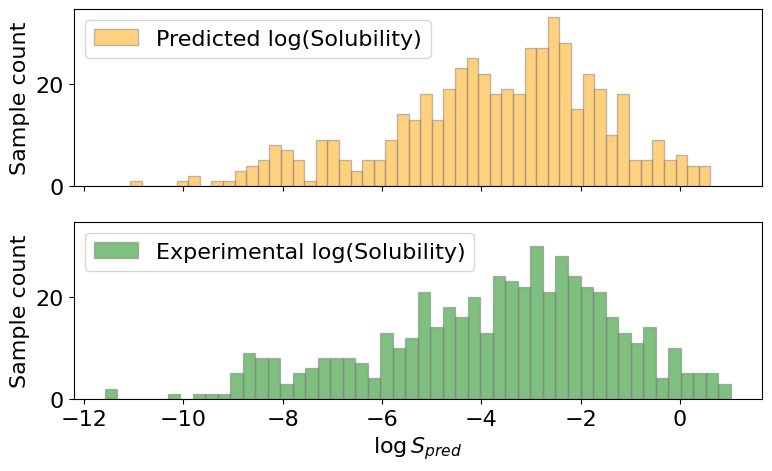

In [580]:
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex='all', sharey='all')
ax1, ax2 = axes
ax1.hist(y_pred,bins=50,color='orange',edgecolor='gray',alpha=0.5,label='Predicted log(Solubility)')
ax1.set_ylabel('Sample count')
ax1.legend()
ax2.hist(y_test,bins=50,color='green',edgecolor='gray',alpha=0.5, label='Experimental log(Solubility)')
ax2.set_ylabel('Sample count')
ax2.set_xlabel(r'$\log S_{pred}$')
ax2.legend()
plt.tight_layout()